In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline

from sklearn import preprocessing as pp 
from scipy.stats import pearsonr 
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount("/gdrive")
%cd /gdrive/MyDrive/dacon/anomaly_detection

Mounted at /gdrive
/gdrive/MyDrive/dacon/anomaly_detection


In [ ]:
train = pd.read_csv('data/train.csv')
train.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,6,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,8,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,9,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


In [ ]:
train.isna().sum() # 결측치 없음

ID     0
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
dtype: int64

In [ ]:
train.shape

(113842, 31)

In [ ]:
train.nunique() # id는 고유 나머지는 중복이 조금 있는데 v1~v28까진 일정하지만 v29,v30은 급격히 떨어짐

ID     113842
V1     111739
V2     111739
V3     111739
V4     111739
V5     111739
V6     111739
V7     111739
V8     111739
V9     111739
V10    111739
V11    111739
V12    111739
V13    111739
V14    111739
V15    111739
V16    111739
V17    111739
V18    111739
V19    111739
V20    111739
V21    111739
V22    111739
V23    111739
V24    111739
V25    111739
V26    111739
V27    111739
V28    111739
V29     20439
V30     77598
dtype: int64

In [ ]:
train.describe()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
count,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,...,113842.000000,1.138420e+05,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000
mean,142025.527837,0.000197,0.001289,0.009717,-0.004169,0.000475,0.005141,0.005769,-0.002451,-0.002107,...,-0.001242,4.088347e-07,-0.001317,-0.000884,0.001680,-0.000293,-0.000234,-0.000508,0.927253,0.116232
std,82248.545392,1.951060,1.651064,1.496916,1.412633,1.367533,1.330583,1.204111,1.185504,1.095415,...,0.722001,7.238291e-01,0.636061,0.605854,0.520069,0.480979,0.399505,0.356130,3.412933,0.558161
min,3.000000,-56.407510,-72.715728,-32.454198,-5.600607,-42.147898,-26.160506,-41.506796,-50.943369,-13.434066,...,-22.757540,-8.887017e+00,-44.807735,-2.824849,-10.295397,-1.855355,-9.895244,-9.617915,-0.307413,-0.994972
25%,70796.750000,-0.923479,-0.595602,-0.883877,-0.853728,-0.689853,-0.766094,-0.552071,-0.209492,-0.647477,...,-0.229710,-5.402665e-01,-0.162180,-0.355582,-0.315470,-0.326160,-0.070847,-0.053249,-0.230560,-0.360304
50%,141722.000000,0.012074,0.066390,0.183868,-0.019359,-0.054060,-0.272436,0.039036,0.020970,-0.052157,...,-0.030281,8.345807e-03,-0.012261,0.040573,0.018278,-0.052815,0.001502,0.011158,-0.000699,-0.002590
75%,213359.500000,1.315373,0.801687,1.037120,0.742208,0.614214,0.405285,0.568750,0.328303,0.590705,...,0.186001,5.287508e-01,0.147474,0.438225,0.353989,0.240838,0.091279,0.077851,0.768532,0.640653
max,284803.000000,2.454930,21.467203,4.187811,16.491217,34.801666,23.917837,44.054461,20.007208,10.392889,...,27.202839,8.361985e+00,22.528412,4.022866,7.519589,3.119295,11.135740,33.847808,180.101027,1.034951


In [ ]:
val = pd.read_csv('data/val.csv')
val.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,10,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,22,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,63,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,69,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,83,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


In [ ]:
val.describe()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
count,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,...,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000
mean,142549.840138,0.004967,0.002014,0.001414,0.001893,-0.003969,-0.017730,0.005556,0.009023,-0.004905,...,0.001224,0.001490,0.001355,0.002284,0.000520,-0.000520,-0.000265,0.924010,0.119916,0.001054
std,82252.851474,1.930640,1.605198,1.499749,1.405139,1.335147,1.292214,1.165132,1.103538,1.090843,...,0.721350,0.588076,0.603181,0.526864,0.484804,0.394235,0.304284,3.347555,0.558246,0.032449
min,10.000000,-29.516123,-38.305310,-30.177317,-5.071241,-21.577019,-16.172614,-31.197329,-26.278007,-9.462573,...,-8.555808,-25.356744,-2.807897,-6.035054,-1.596493,-9.793568,-8.364853,-0.307413,-0.994878,0.000000
25%,71260.000000,-0.915525,-0.598053,-0.873022,-0.852444,-0.698010,-0.774920,-0.546290,-0.210941,-0.642760,...,-0.542624,-0.160418,-0.352310,-0.322098,-0.328638,-0.071787,-0.052361,-0.226927,-0.357884,0.000000
50%,142683.500000,0.023586,0.075470,0.175784,-0.021619,-0.052780,-0.280742,0.046280,0.022622,-0.066623,...,0.008401,-0.011372,0.040076,0.016684,-0.049583,0.000488,0.012138,0.005589,0.002156,0.000000
75%,213612.750000,1.315578,0.803463,1.011563,0.739044,0.598712,0.377266,0.566825,0.323836,0.596308,...,0.528163,0.146094,0.441402,0.352930,0.241051,0.089100,0.080822,0.778278,0.641828,0.000000
max,284806.000000,2.411769,16.497472,4.226108,12.114672,24.345310,12.128950,26.237722,12.431140,7.937413,...,6.090514,18.946734,3.658746,5.525093,3.067907,8.708972,15.726807,165.948299,1.034975,1.000000


## Train/Validation Feature 분포 확인

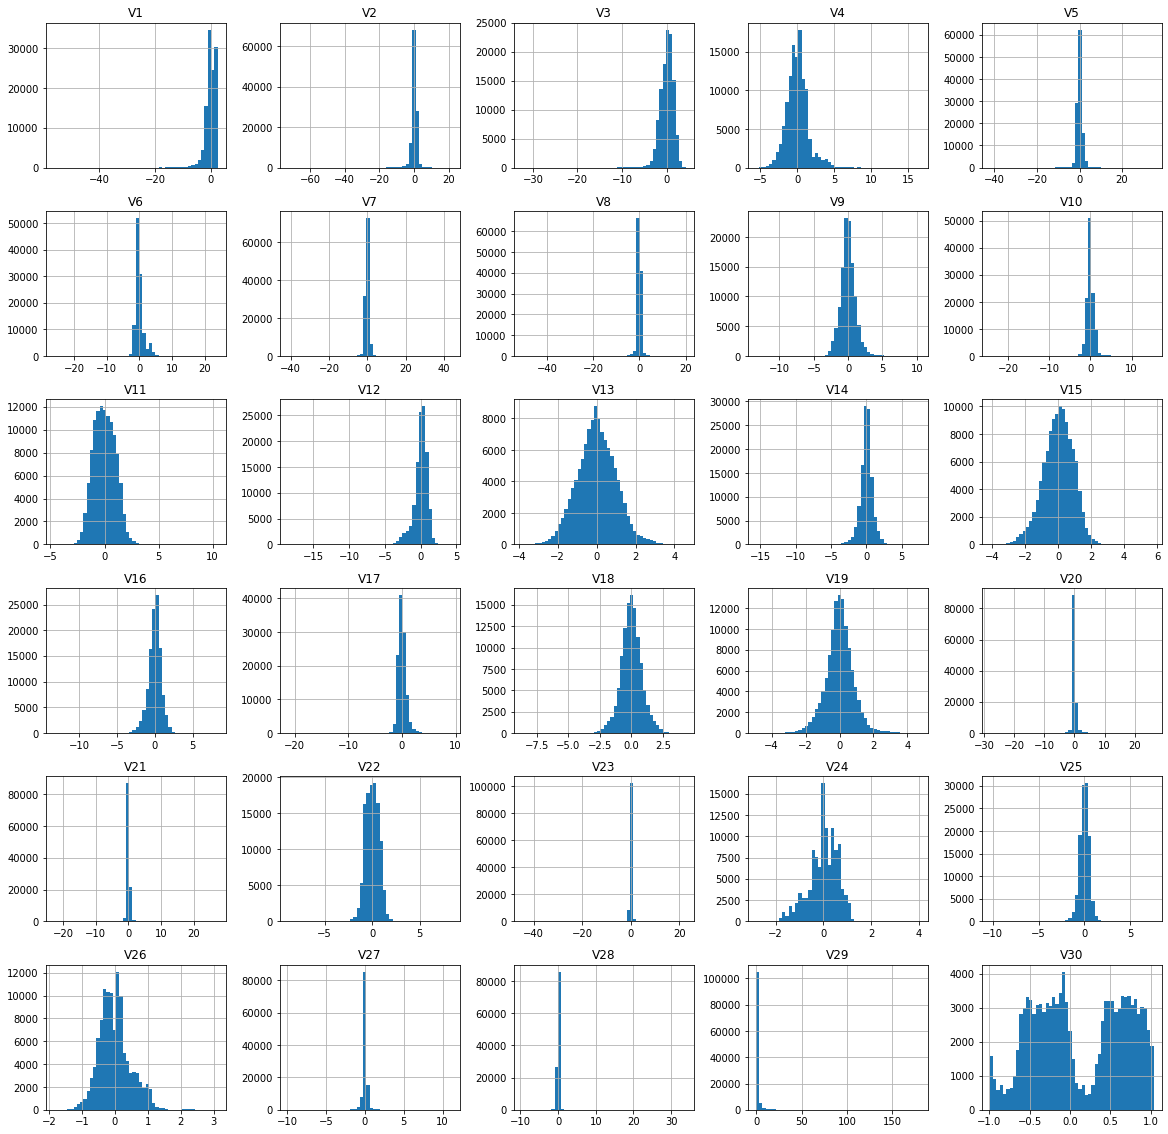

In [ ]:
# Train 확인
train.drop(columns = ['ID']).hist(bins=50, figsize = (20,20))
plt.show()

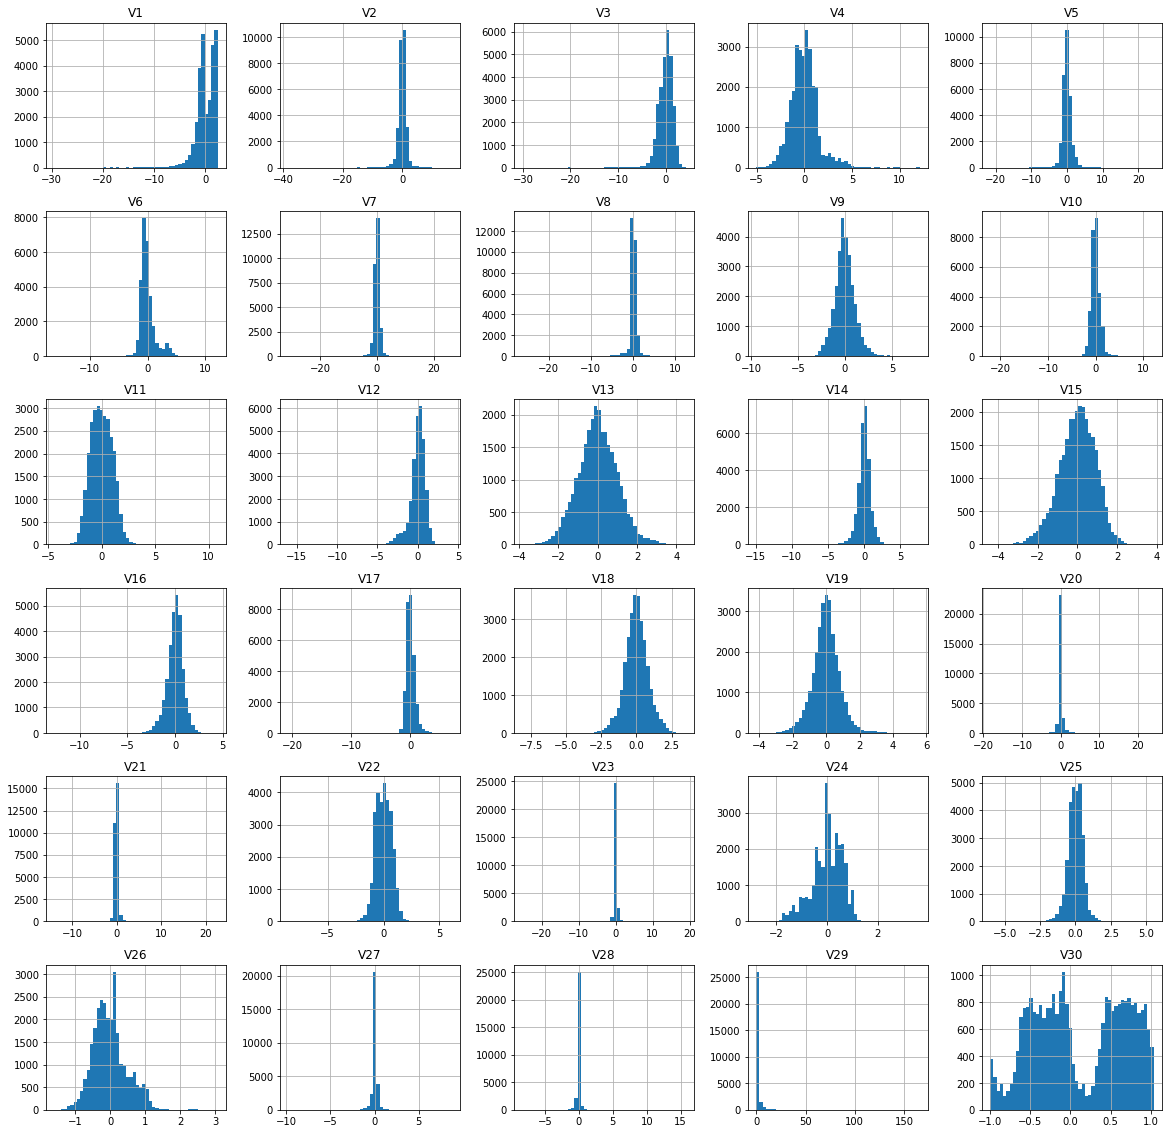

In [ ]:
# Validation 확인
val.drop(columns=['ID', 'Class']).hist(bins = 50, figsize = (20,20))
plt.show()

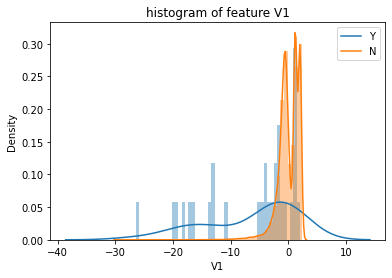

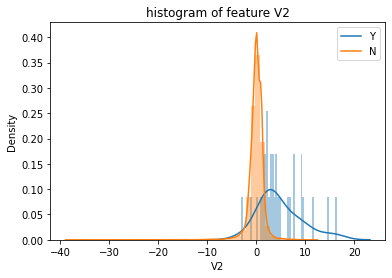

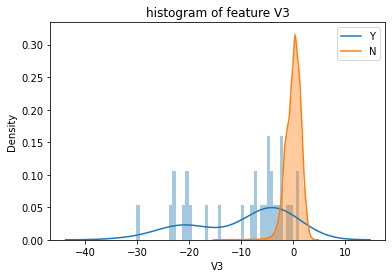

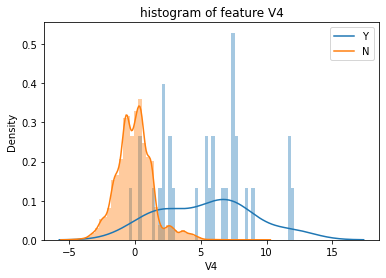

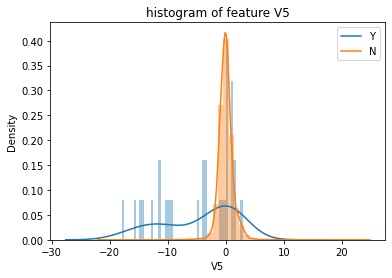

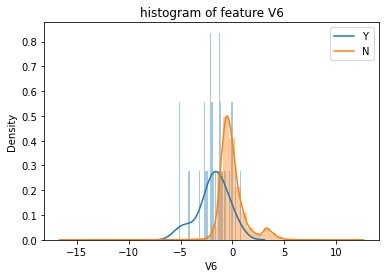

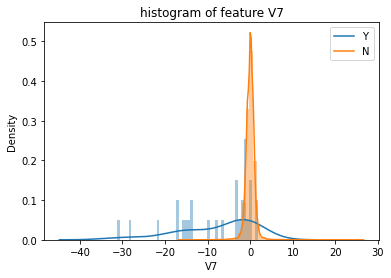

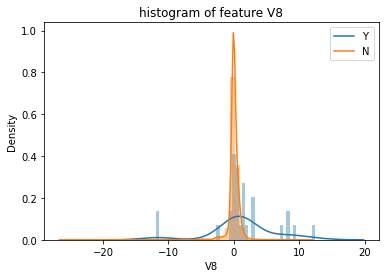

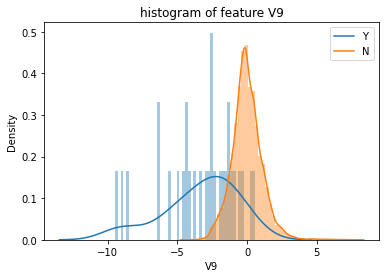

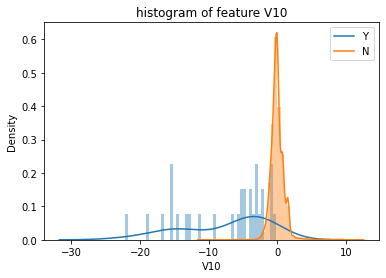

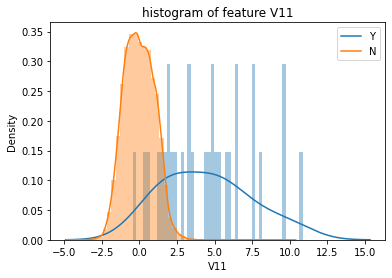

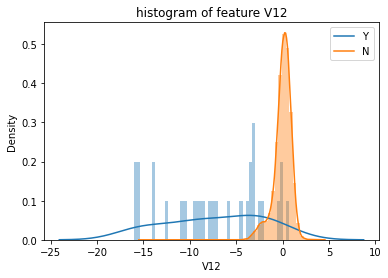

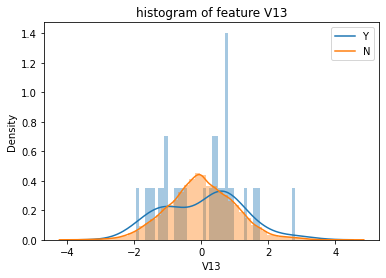

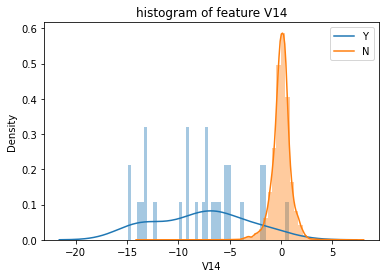

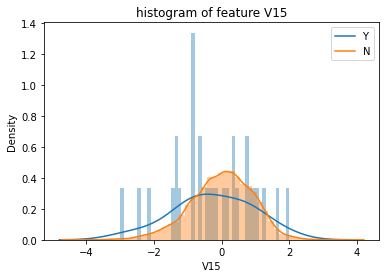

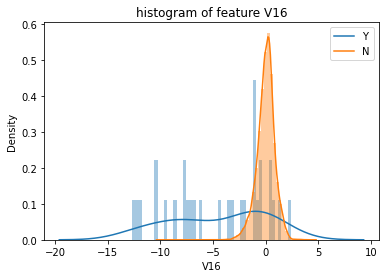

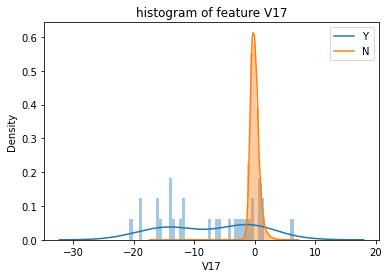

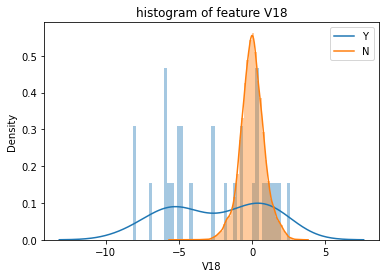

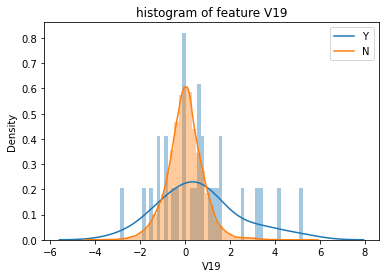

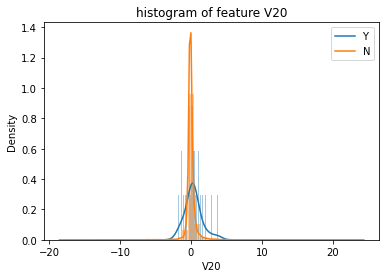

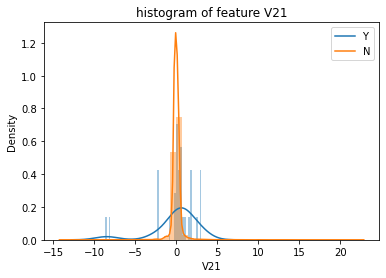

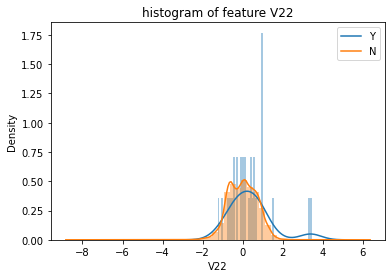

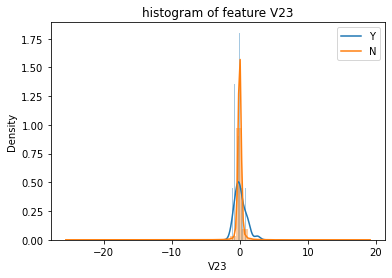

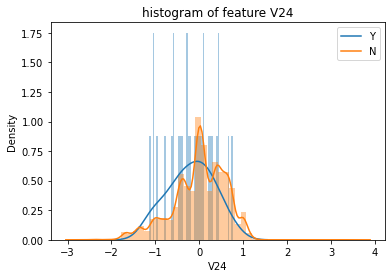

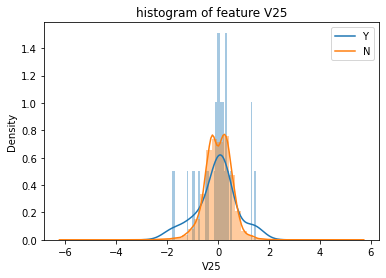

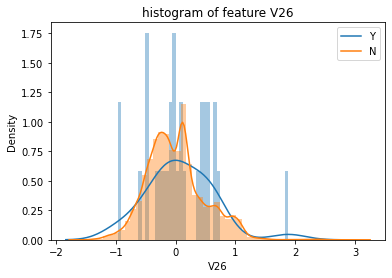

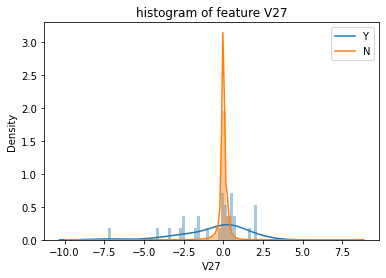

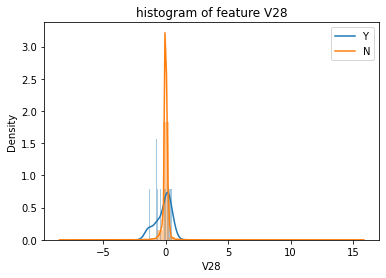

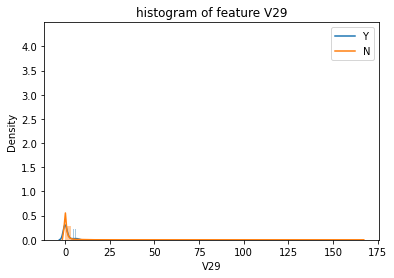

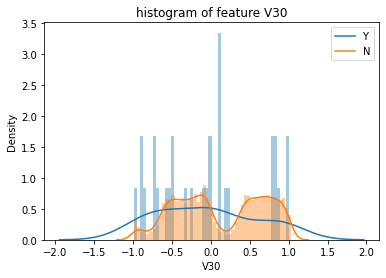

In [ ]:
import seaborn as sns

features = val.iloc[:,1:31].columns
for cnt, col in enumerate(val[features]):
    sns.distplot(val[col][val.Class==1], bins=50)
    sns.distplot(val[col][val.Class==0], bins=50)
    plt.legend(['Y','N'], loc='best')
    plt.title('histogram of feature '+str(col))
    plt.show()

In [ ]:
correlationMatrix=pd.DataFrame(data=[],index=train.columns)
correlationMatrix = pd.DataFrame(data=[],index=train.columns,columns=train.columns)
for i in train.columns:
    for j in train.columns:
        #피어슨 상관계수 활용하여 피처 간 상관관계를 확인
        correlationMatrix.loc[i,j] = np.round(pearsonr(train.loc[:,i],train.loc[:,j])[0],2)

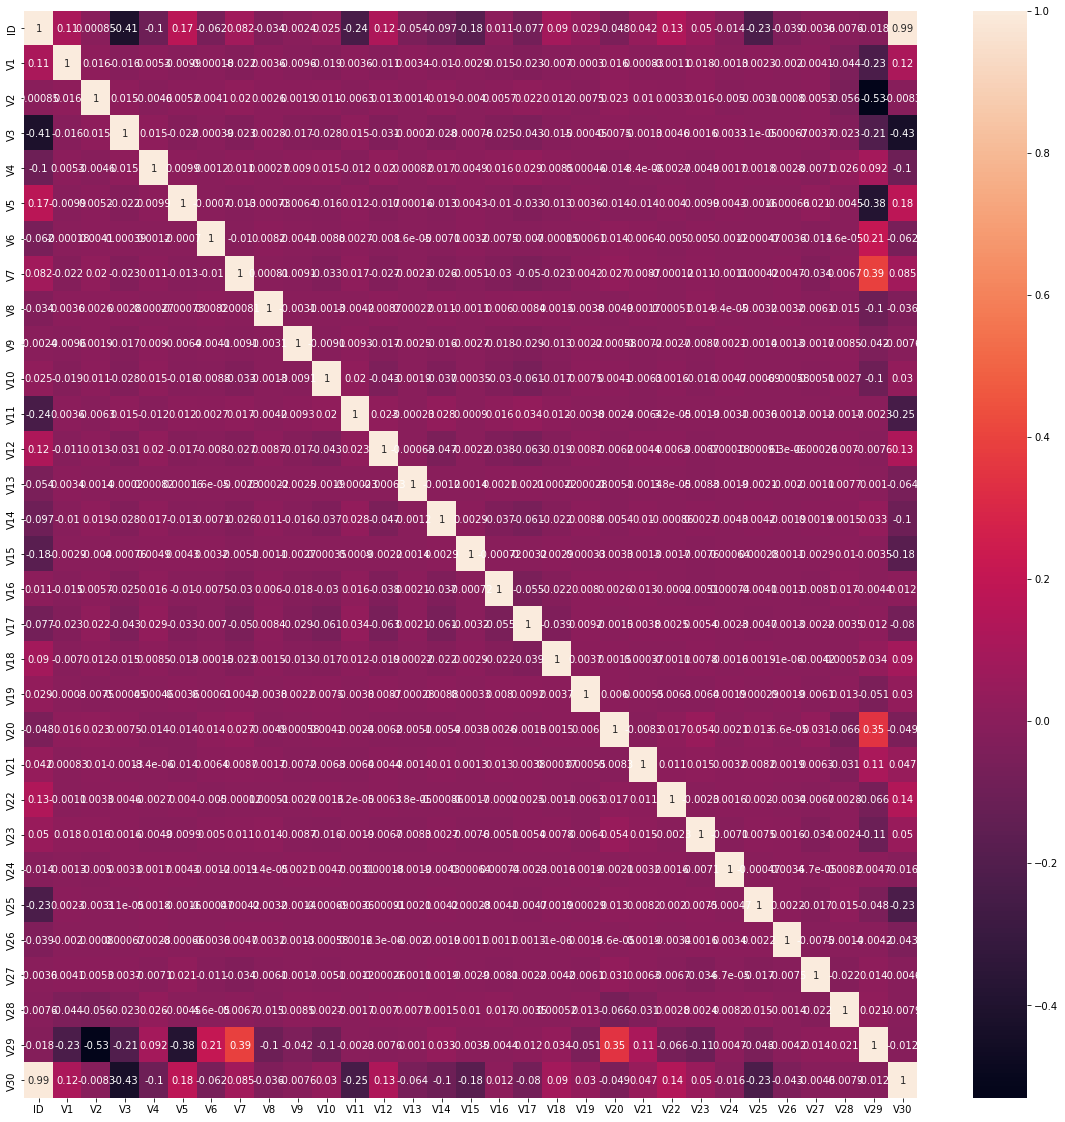

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(),annot=True)

### Validation set 사기 거래 비율


In [ ]:
#validation set의 사기 거래 비율이 다른 데이터 집합에서도 비슷하게 발생
val_normal, val_fraud = val['Class'].value_counts()
val_contamination = val_fraud / val_normal
print(f'Validation contamination:[{val_contamination}]')

Validation contamination:[0.0010551491277433877]


## Model define & fit

In [ ]:
# Train dataset은 Label이 존재하지 않음
train_x = train.drop(columns=['ID','V29','V30']) # Input Data

In [ ]:
from sklearn.decomposition import PCA
# 25개 주성분을 이용하여 PCA 진행
n_components = 25
whiten = False
random_state = 2022

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

train_x_PCA = pca.fit_transform(train_x)
train_x_PCA = pd.DataFrame(data=train_x_PCA, index=train_x.index)

train_x_PCA_inverse = pca.inverse_transform(train_x_PCA)
train_x_PCA_inverse = pd.DataFrame(data=train_x_PCA_inverse, \
                                   index=train_x.index)

In [ ]:
# model parameter : contamination=0.003 적용
model = IsolationForest(n_estimators=100, max_samples=len(train_x_PCA_inverse), contamination=0.003, random_state=42, verbose=0)
model.fit(train_x)

IsolationForest(contamination=0.003, max_samples=113842, random_state=42)

## Evaluation : Validation set

In [ ]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [ ]:
val_x = val.drop(columns=['ID', 'Class','V29','V30']) # Input Data

val_y = val['Class'] # Label

val_x_PCA = pca.fit_transform(val_x)
val_x_PCA = pd.DataFrame(data=val_x_PCA, index=val_x.index)

val_x_PCA_inverse = pca.inverse_transform(val_x_PCA)
val_x_PCA_inverse = pd.DataFrame(data=val_x_PCA_inverse, \
                                   index=val_x.index)

val_pred = model.predict(val_x_PCA_inverse) # model prediction
val_pred = get_pred_label(val_pred)
val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))

Validation F1 Score : [0.6972169781598783]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.30      0.57      0.40        30

    accuracy                           1.00     28462
   macro avg       0.65      0.78      0.70     28462
weighted avg       1.00      1.00      1.00     28462



In [ ]:
test_df = pd.read_csv('data/test.csv') # Test
test_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,AAAA0x1,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,AAAA0x2,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,AAAA0x5,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,AAAA0x7,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,AAAA0xc,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866


In [ ]:
test_x = test_df.drop(columns=['ID','V29','V30'])

test_df_PCA = pca.fit_transform(test_x)
test_df_PCA = pd.DataFrame(data=test_df_PCA, index=test_x.index)

test_df_PCA_inverse = pca.inverse_transform(test_df_PCA)
test_df_PCA_inverse = pd.DataFrame(data=test_df_PCA_inverse, \
                                   index=test_x.index)


In [ ]:
test_pred = model.predict(test_x) # model prediction
test_pred = get_pred_label(test_pred)

In [ ]:
submit = pd.read_csv('data/sample_submission.csv')
submit.head()

,ID,Class
0,AAAA0x1,1
1,AAAA0x2,1
2,AAAA0x5,1
3,AAAA0x7,1
4,AAAA0xc,1


In [ ]:
submit['Class'] = test_pred
submit['Class'].value_counts()

0    141986
1       517
Name: Class, dtype: int64

In [ ]:
submit.to_csv('submissions/submits.csv', index=False)